In [54]:
import pandas as pd
import numpy as np

In [55]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Get data

In [56]:
full_date_range = pd.DataFrame({'date': pd.date_range(start='2004-01-01', end='2024-01-01')})


In [57]:
d_signals = pd.read_csv('/content/drive/My Drive/CIS-5190-Project/Code/signals/daniel_signals.csv', header = 0)
d_signals['date'] = pd.to_datetime(d_signals['date'])

In [58]:
d_signals = d_signals[['date', 'us_inflation']]

In [59]:
a_signals = pd.read_csv('/content/drive/My Drive/CIS-5190-Project/Code/signals/china_gdp_cpi.csv', header = 0)
a_signals['date'] = pd.to_datetime(a_signals['DATE'])
a_signals.rename(columns={'China_CPI' : 'china_inflation', 'China_GDP':'china_gdp'}, inplace=True)
a_signals = a_signals[['date', 'china_gdp', 'china_inflation']]

In [60]:
i_signals = pd.read_csv('/content/drive/My Drive/CIS-5190-Project/Code/signals/us_econ_indic.csv', header = 0)
i_signals.rename(columns={'US_interest_rates': 'us_interest_rates', 'US_unemployment': 'us_unemployment', 'US_GDP': 'us_gdp', 'US_debt': 'us_debt'}, inplace=True)
i_signals = i_signals.iloc[:8767]
i_signals['date'] = pd.to_datetime(i_signals['date'])


<ipython-input-60-beeff0654215>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  i_signals['date'] = pd.to_datetime(i_signals['date'])


In [61]:
rates = pd.read_csv('/content/drive/My Drive/CIS-5190-Project/Code/signals/rates.csv', header = 0)

In [62]:
rates.rename(columns = {'datadate': 'date', 'exratd_fromUSD': 'rate'}, inplace=True)

In [63]:
rates= rates[['date', 'rate']]
rates['date'] = pd.to_datetime(rates['date'])

In [64]:
data = full_date_range.merge(d_signals, on='date', how = 'left')
data = data.merge(a_signals, on='date', how = 'left')
data = data.merge(i_signals, on='date', how = 'left')
data = data.merge(rates, on='date', how = 'left')
data.dropna(inplace=True)

In [65]:
data.columns

Index(['date', 'us_inflation', 'china_gdp', 'china_inflation',
       'us_interest_rates', 'us_unemployment', 'us_gdp', 'us_debt', 'rate'],
      dtype='object')

In [76]:
from sklearn.preprocessing import MinMaxScaler

scalers = {}

feature_columns = [col for col in data.columns if col not in ['date', 'rate']]
scaler = MinMaxScaler()
data[feature_columns] = scaler.fit_transform(data[feature_columns])

output_scaler = MinMaxScaler()
data['rate'] = output_scaler.fit_transform(data[['rate']])

In [77]:
train_data = data[data['date'] < pd.Timestamp('2020-01-01')]
validation_data = data[(data['date'] >= pd.Timestamp('2020-01-01')) & (data['date'] < pd.Timestamp('2022-01-01'))]
test_data = data[data['date'] >= pd.Timestamp('2022-01-01')]

train_features = train_data[feature_columns]
train_target = train_data['rate']

validation_features = validation_data[feature_columns]
validation_target = validation_data['rate']

test_features = test_data[feature_columns]
test_target = test_data['rate']


In [78]:
def create_sequences(features, target, time_steps=1):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 30
X_train, y_train = create_sequences(train_features, train_target.values, time_steps)
X_val, y_val = create_sequences(validation_features, validation_target.values, time_steps)
X_test, y_test = create_sequences(test_features, test_target.values, time_steps)


# Modeling

In [69]:
!pip install tensorflow


## First Try (timestep = 30)

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

model = Sequential([
    LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(30, return_sequences=True),
    Dropout(0.2),
    LSTM(30, return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

Epoch 1/50
180/180 [==============================] - 32s 128ms/step - loss: 0.0293 - val_loss: 0.0759
Epoch 2/50
180/180 [==============================] - 21s 117ms/step - loss: 0.0043 - val_loss: 0.0206
Epoch 3/50
180/180 [==============================] - 21s 115ms/step - loss: 0.0030 - val_loss: 0.0196
Epoch 4/50
180/180 [==============================] - 23s 126ms/step - loss: 0.0024 - val_loss: 0.0186
Epoch 5/50
180/180 [==============================] - 20s 114ms/step - loss: 0.0024 - val_loss: 0.0182
Epoch 6/50
180/180 [==============================] - 21s 119ms/step - loss: 0.0024 - val_loss: 0.0192
Epoch 7/50
180/180 [==============================] - 24s 132ms/step - loss: 0.0022 - val_loss: 0.0165
Epoch 8/50
180/180 [==============================] - 25s 136ms/step - loss: 0.0020 - val_loss: 0.0264
Epoch 9/50
180/180 [==============================] - 23s 126ms/step - loss: 0.0018 - val_loss: 0.0151
Epoch 10/50
180/180 [==============================] - 21s 115ms/step - l

In [91]:
test_predict = model.predict(X_test)

20/20 [==============================] - 2s 27ms/step


In [92]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, test_predict)
rmse = mse**0.5
mae = mean_absolute_error(y_test, test_predict)
r2 = r2_score(y_test, test_predict)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)


Mean Squared Error: 0.01750291708173738
Root Mean Squared Error: 0.1322985906264212
Mean Absolute Error: 0.11479521102711954
R2 Score: -0.7081111621596237


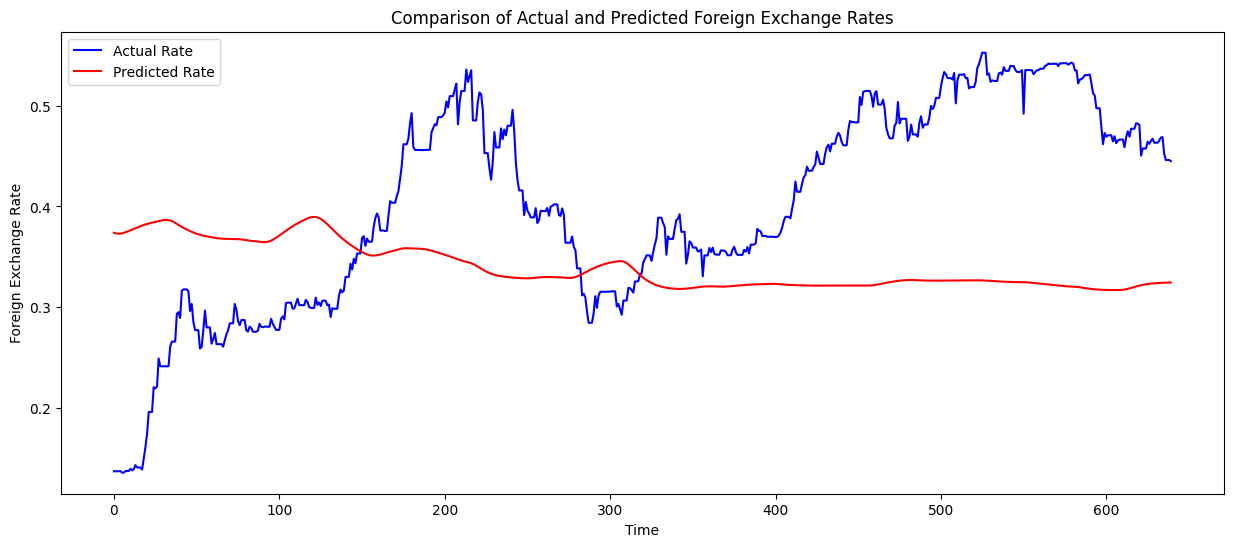

In [93]:
import matplotlib.pyplot as plt

y_test_original = output_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = output_scaler.inverse_transform(test_predict.reshape(-1, 1))

plt.figure(figsize=(15, 6))
plt.plot(y_test_original, label='Actual Rate', color='blue')
plt.plot(y_pred_original, label='Predicted Rate', color='red')
plt.title('Comparison of Actual and Predicted Foreign Exchange Rates')
plt.xlabel('Time')
plt.ylabel('Foreign Exchange Rate')
plt.legend()
plt.show()


## Timestep = 7

In [80]:
def create_sequences(features, target, time_steps=1):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 7
X_train, y_train = create_sequences(train_features, train_target.values, time_steps)
X_val, y_val = create_sequences(validation_features, validation_target.values, time_steps)
X_test, y_test = create_sequences(test_features, test_target.values, time_steps)




In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

short_model = Sequential([
    LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(30, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

short_model.compile(optimizer='adam', loss='mean_squared_error')

short_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

Epoch 1/50
183/183 [==============================] - 6s 15ms/step - loss: 0.0368 - val_loss: 0.1849
Epoch 2/50
183/183 [==============================] - 2s 9ms/step - loss: 0.0142 - val_loss: 0.0979
Epoch 3/50
183/183 [==============================] - 2s 13ms/step - loss: 0.0089 - val_loss: 0.0370
Epoch 4/50
183/183 [==============================] - 3s 14ms/step - loss: 0.0064 - val_loss: 0.0291
Epoch 5/50
183/183 [==============================] - 2s 11ms/step - loss: 0.0053 - val_loss: 0.0283
Epoch 6/50
183/183 [==============================] - 2s 9ms/step - loss: 0.0049 - val_loss: 0.0388
Epoch 7/50
183/183 [==============================] - 2s 9ms/step - loss: 0.0046 - val_loss: 0.0399
Epoch 8/50
183/183 [==============================] - 2s 9ms/step - loss: 0.0043 - val_loss: 0.0599
Epoch 9/50
183/183 [==============================] - 2s 9ms/step - loss: 0.0043 - val_loss: 0.0598
Epoch 10/50
183/183 [==============================] - 2s 9ms/step - loss: 0.0040 - val_loss: 0.

In [82]:
test_predict = short_model.predict(X_test)

23/23 [==============================] - 1s 3ms/step


In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, test_predict)
rmse = mse**0.5
mae = mean_absolute_error(y_test, test_predict)
r2 = r2_score(y_test, test_predict)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)


Mean Squared Error: 0.044122907314984826
Root Mean Squared Error: 0.21005453414526626
Mean Absolute Error: 0.1668304925782058
R2 Score: -1.672024668739747


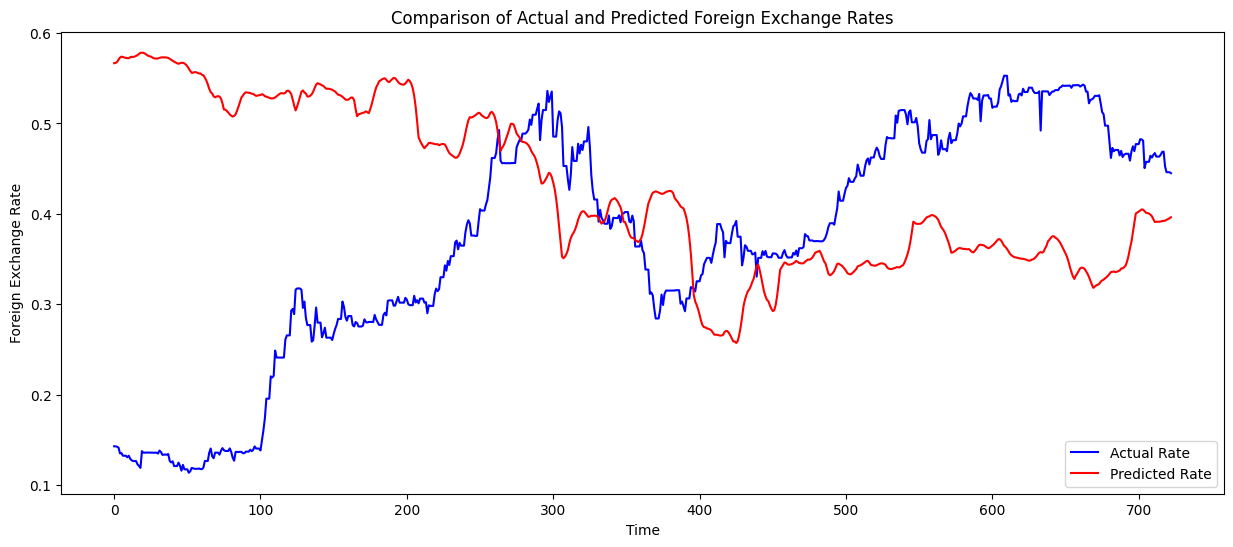

In [84]:
import matplotlib.pyplot as plt

y_test_original = output_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = output_scaler.inverse_transform(test_predict.reshape(-1, 1))

plt.figure(figsize=(15, 6))
plt.plot(y_test_original, label='Actual Rate', color='blue')
plt.plot(y_pred_original, label='Predicted Rate', color='red')
plt.title('Comparison of Actual and Predicted Foreign Exchange Rates')
plt.xlabel('Time')
plt.ylabel('Foreign Exchange Rate')
plt.legend()
plt.show()


## Timestep = 90

In [85]:
def create_sequences(features, target, time_steps=1):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 90
X_train, y_train = create_sequences(train_features, train_target.values, time_steps)
X_val, y_val = create_sequences(validation_features, validation_target.values, time_steps)
X_test, y_test = create_sequences(test_features, test_target.values, time_steps)




In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

long_model = Sequential([
    LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(30, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

long_model.compile(optimizer='adam', loss='mean_squared_error')

long_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

Epoch 1/50
180/180 [==============================] - 19s 85ms/step - loss: 0.0195 - val_loss: 0.0776
Epoch 2/50
180/180 [==============================] - 14s 79ms/step - loss: 0.0070 - val_loss: 0.0319
Epoch 3/50
180/180 [==============================] - 14s 80ms/step - loss: 0.0054 - val_loss: 0.0438
Epoch 4/50
180/180 [==============================] - 14s 79ms/step - loss: 0.0047 - val_loss: 0.0384
Epoch 5/50
180/180 [==============================] - 14s 79ms/step - loss: 0.0040 - val_loss: 0.0513
Epoch 6/50
180/180 [==============================] - 14s 80ms/step - loss: 0.0039 - val_loss: 0.0498
Epoch 7/50
180/180 [==============================] - 14s 78ms/step - loss: 0.0033 - val_loss: 0.0574
Epoch 8/50
180/180 [==============================] - 14s 76ms/step - loss: 0.0031 - val_loss: 0.0564
Epoch 9/50
180/180 [==============================] - 14s 76ms/step - loss: 0.0030 - val_loss: 0.0599
Epoch 10/50
180/180 [==============================] - 13s 74ms/step - loss: 0.002

In [87]:
test_predict = long_model.predict(X_test)

20/20 [==============================] - 1s 18ms/step


In [88]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, test_predict)
rmse = mse**0.5
mae = mean_absolute_error(y_test, test_predict)
r2 = r2_score(y_test, test_predict)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)


Mean Squared Error: 0.014446995930866156
Root Mean Squared Error: 0.12019565687189432
Mean Absolute Error: 0.09347426191335029
R2 Score: -0.4098835579204856


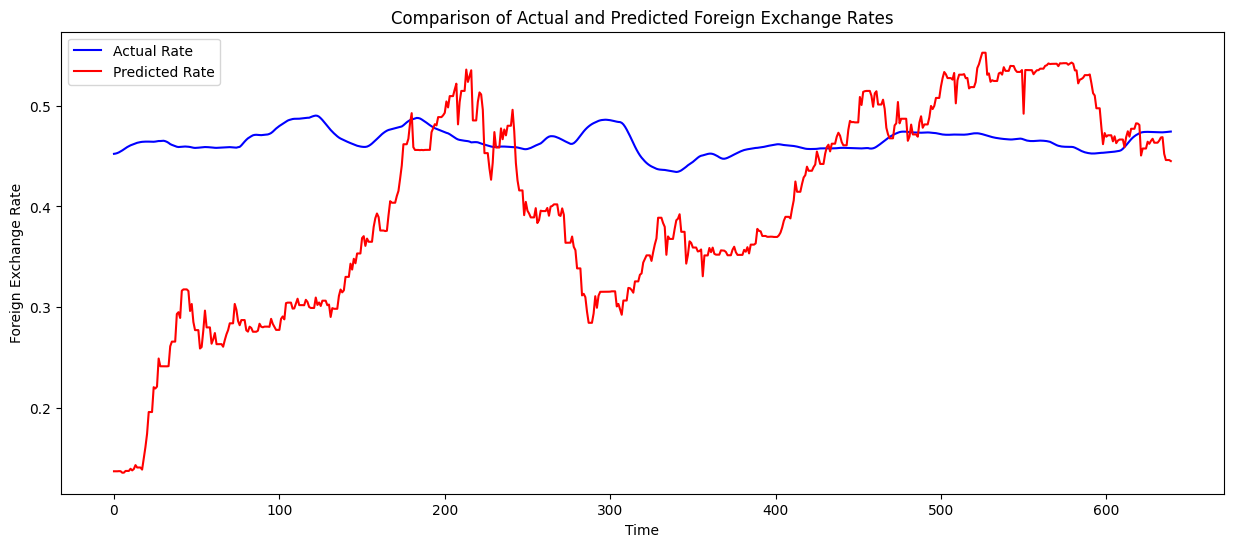

In [89]:
import matplotlib.pyplot as plt

y_pred_original = output_scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_original = output_scaler.inverse_transform(test_predict.reshape(-1, 1))

plt.figure(figsize=(15, 6))
plt.plot(y_test_original, label='Actual Rate', color='blue')
plt.plot(y_pred_original, label='Predicted Rate', color='red')
plt.title('Comparison of Actual and Predicted Foreign Exchange Rates')
plt.xlabel('Time')
plt.ylabel('Foreign Exchange Rate')
plt.legend()
plt.show()
